## Load

In [23]:
import torch
from torch.utils import data
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from diffusion import GaussianDiffusion, Trainer
from unet import UNet

image_size = (128, 128)

diffusion = torch.load("/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/diffseis/results_demultiple1/model-1400.pt")
# diffusion = torch.load("/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/diffseis/results_demultiple/model-1000.pt")


/tmp/ipykernel_180839/3848763096.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffusion = torch.load("/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/diffseis/results_

## Test

In [2]:
from scipy.ndimage import zoom
from PIL import Image

from utools import random_thick_vs, get_dshift, fj


def show_fj(f, c, out, fmin, fmax, ii, aa):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.axis("off")
    ax.imshow(out, aspect='auto', cmap='gray',
            extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')

    ax.margins(0)
    ax.set_xlim(fmin, fmax)
    ax.set_ylim(c.min(), c.max())
    fig.savefig(f'/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/diffseis/dataset/demultiple/data_train/test/{aa}{ii:03d}.png',
                dpi=300,bbox_inches='tight', pad_inches=0)
    plt.close()

image_size = (128, 128)
test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Grayscale(num_output_channels=1),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])

sampling loop time step: 100%|██████████| 2000/2000 [00:13<00:00, 149.28it/s]


(128, 128)


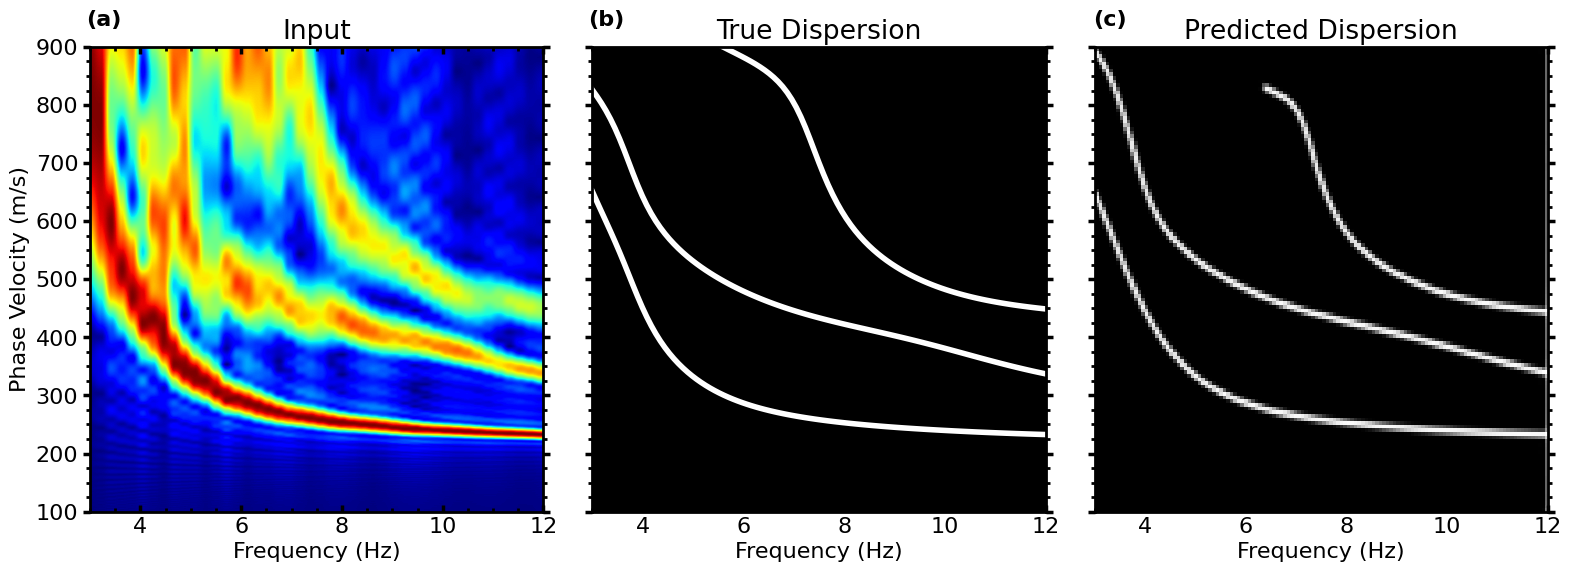

In [3]:
import numpy as np
import random
import concurrent.futures
from matplotlib.ticker import MultipleLocator, AutoMinorLocator


# Frequency axis
fdisp = np.linspace(3, 12, 101)
period = np.flipud(1/fdisp)         # Periods (must be sorted starting with low periods)

# Axes
nt = 600 # number of time samples
dt = 0.008 # time sampling in s
nx = 201 # number of spatial samples
dx = 2 # spatial sampling in m
nfft = 2**10

dc = 2.
cmin, cmax = 100., 900.
fmin, fmax = fdisp.min(), fdisp.max()



# 原始数组
# thick = np.array([0.01, 0.02, 0.03, 0.01])
# vs = np.array([0.2, 0.4, 0.6, 0.8])
fluctuation_percentage = 0.0001        # 定义浮动范围百分比


# h1 = np.random.uniform(0.005, 0.01)
# h2 = np.random.uniform(0.01, 0.02)
# h3 = np.random.uniform(0.01, 0.02)
# h4 = 1.0
# v1 = np.random.uniform(0.1, 0.3)
# v2 = np.random.uniform(0.1, 0.4)
# v3 = np.random.uniform(0.2, 0.6)
# v4 = np.random.uniform(0.8, 0.9)


# --------------------------------------------------------------------------------
# Best model out of 90000 models (1 run)

# Velocity model                                    Model parameters
# ----------------------------------------          ------------------------------
#          d        vp        vs       rho                   d        vs        nu
#       [km]    [km/s]    [km/s]   [g/cm3]                [km]    [km/s]       [-]
# ----------------------------------------          ------------------------------
#     0.0109    0.3809    0.2332    0.5678              0.0109    0.2332    0.2000
#     0.0150    0.4640    0.2842    0.6757              0.0150    0.2842    0.2000
#     0.0135    0.8782    0.5000    1.1377              0.0135    0.5000    0.2601
#     0.0129    0.6532    0.4000    0.9016              0.0129    0.4000    0.2000
#     1.0000    2.4495    1.0000    2.0772                   -    1.0000    0.4000

h1, h2, h3, h4, h5 = 0.0109, 0.0150, 0.0135, 0.0129, 1.0000
v1, v2, v3, v4, v5 = 0.2332, 0.2842, 0.5000, 0.4000, 1.0000

thick = np.array([h1, h2, h3, h4, h5])
vs = np.array([v1, v2, v3, v4, v5])

cpr = random_thick_vs(thick, vs, period, fluctuation_percentage)
dshift = get_dshift(nt, dt, nx, dx, nfft, cpr)
f, c, out = fj(dshift, dx, dt, cmin, cmax)


show_fj(f, c, out, fmin, fmax, 0, "test")
img_data = Image.open('/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/diffseis/dataset/demultiple/data_train/test/test000.png')

x_start = test_transform(img_data)
x_start = torch.unsqueeze(x_start, dim=0)


out1 = diffusion.inference(x_in=x_start.cuda())

in_samples = out1[0,0].cpu().detach().numpy()
out_samples = out1[1,0].cpu().detach().numpy()
print(out_samples.shape)



plt.rcParams.update({
    # 'font.family': 'Arial',
    'font.size': 16
})

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

axes[0].imshow(out, aspect='auto', cmap='jet',
    extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')
axes[0].set_xlim(fmin, fmax)
axes[0].set_ylim(c.min(), c.max())


axes[1].imshow(np.zeros_like(out), aspect='auto', cmap='gray',
    extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')
for imode in range(3):
    axes[1].plot(np.flipud(1/cpr[imode][0]), 1.e3*np.flipud(cpr[imode][1]), 
                'white', lw=4)
axes[1].set_xlim(fmin, fmax)
axes[1].set_ylim(c.min(), c.max())

axes[2].imshow(out_samples, cmap="Greys_r", aspect='auto', extent=(fmin, fmax,c.min(), c.max()))
axes[2].set_xlim(fmin, fmax)
axes[2].set_ylim(c.min(), c.max())

# 隐藏纵坐标值但保留刻度
axes[1].tick_params(axis='y', labelleft=False)  # 隐藏纵坐标值
axes[2].tick_params(axis='y', labelleft=False)  # 隐藏纵坐标值


axes[0].set_title("Input")
axes[1].set_title("True Dispersion")
axes[2].set_title("Predicted Dispersion")
axes[0].set_xlabel("Frequency (Hz)")
axes[1].set_xlabel("Frequency (Hz)")
axes[2].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Phase Velocity (m/s)")

for ax in axes:
    # 设置X轴
    ax.xaxis.set_major_locator(MultipleLocator(2))    # 每隔5单位设置一个主要刻度
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))   # 设置次要刻度，主要刻度之间4个小刻度
    # 调整主要刻度线的长度和宽度
    ax.tick_params(axis='x', which='major', length=5, width=2.5, direction='in', top=True, bottom=True)#, labeltop=True, labelbottom=True)  
    # 调整次要刻度线的长度和宽度
    ax.tick_params(axis='x', which='minor', length=3, width=2, direction='in', top=True, bottom=True)
    # 关闭次要刻度的数字标签
    ax.tick_params(axis='x', which='minor', labelbottom=False)

    ax.yaxis.set_major_locator(MultipleLocator(100))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='y', which='major', length=5, width=2.5, left=True, right=True)
    ax.tick_params(axis='y', which='minor', length=3, width=2, left=True, right=True)
    ax.tick_params(axis='y', which='minor', labelbottom=False)

    # 调整边框的粗细
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # 将所有边框的线宽设置为2.5

# 在每个子图的左上角添加标注 (a), (b), (c), (d)
labels = ['(a)', '(b)', '(c)', '(d)']
positions = [(0.07, 1.08), (0.07, 1.08), (0.07, 1.08), (0.07, 1.08)]  # 坐标调整以适应子图位置
for i, ax in enumerate(axes.flat):
    ax.text(positions[i][0], positions[i][1], labels[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.3'))


fig.tight_layout()


## True Data

### True Dispersion

In [4]:
import pickle

car_imgs, f, c = pickle.load(open('car_imgs.pkl', 'rb'))

fmin, fmax = f.min(), f.max()
cmin, cmax = c.min(), c.max()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis("off")
ax.imshow(car_imgs, aspect='auto', cmap='gray',
        extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')

ax.margins(0)
ax.set_xlim(fmin, fmax)
ax.set_ylim(c.min(), c.max())
fig.savefig(f'/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/diffseis/dataset/demultiple/data_train/test/true000.png',
            dpi=300,bbox_inches='tight', pad_inches=0)
plt.close()

sampling loop time step: 100%|██████████| 2000/2000 [00:10<00:00, 182.35it/s]


(128, 128)


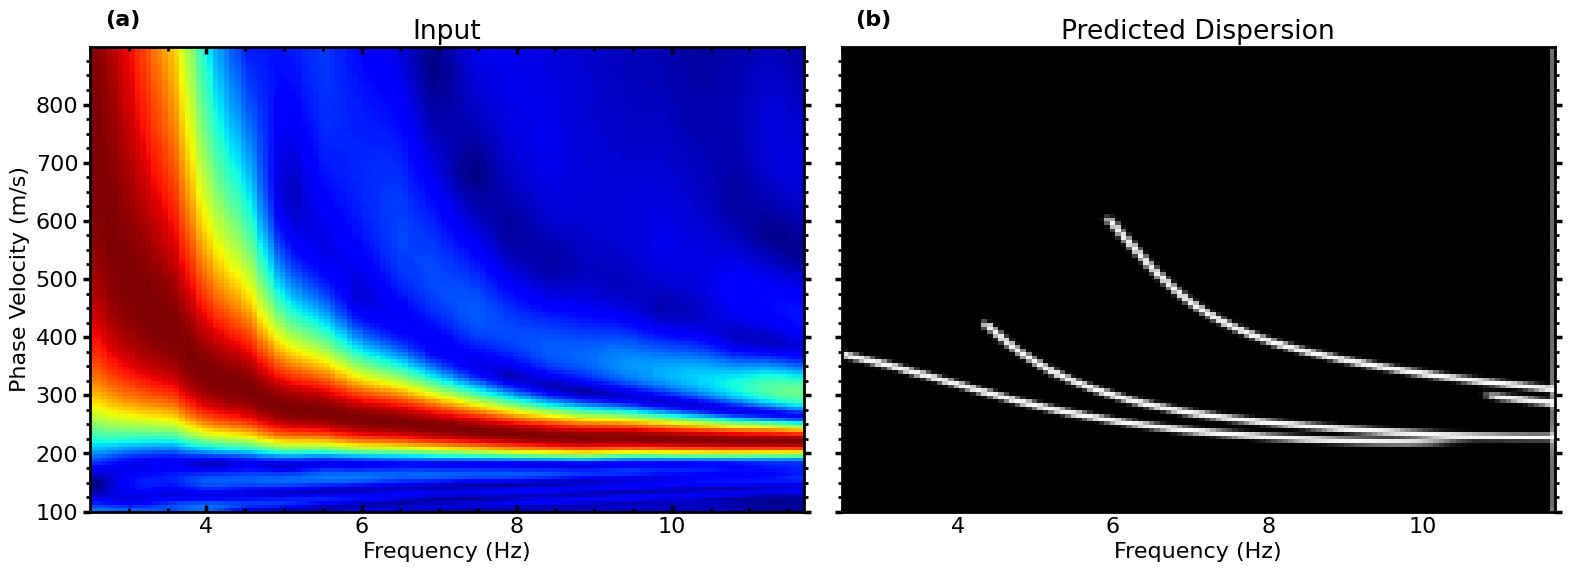

In [5]:
img_data = Image.open('/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/diffseis/dataset/demultiple/data_train/test/true000.png')

x_start = test_transform(img_data)
x_start = torch.unsqueeze(x_start, dim=0)


out1 = diffusion.inference(x_in=x_start.cuda())

in_samples = out1[0,0].cpu().detach().numpy()
out_samples = out1[1,0].cpu().detach().numpy()
print(out_samples.shape)


plt.rcParams.update({
    # 'font.family': 'Arial',
    'font.size': 16
})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].imshow(in_samples, aspect='auto', cmap='jet',
    extent=(f.min(), f.max(),c.min(), c.max()))
axes[0].set_xlim(fmin, fmax)
axes[0].set_ylim(c.min(), c.max())

axes[1].imshow(out_samples, cmap="Greys_r", aspect='auto', extent=(fmin, fmax,c.min(), c.max()))
axes[1].set_xlim(fmin, fmax)
axes[1].set_ylim(c.min(), c.max())

# 隐藏纵坐标值但保留刻度
axes[1].tick_params(axis='y', labelleft=False)  # 隐藏纵坐标值

axes[0].set_title("Input")
axes[1].set_title("Predicted Dispersion")
axes[0].set_xlabel("Frequency (Hz)")
axes[1].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Phase Velocity (m/s)")

for ax in axes:
    # 设置X轴
    ax.xaxis.set_major_locator(MultipleLocator(2))    # 每隔5单位设置一个主要刻度
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))   # 设置次要刻度，主要刻度之间4个小刻度
    # 调整主要刻度线的长度和宽度
    ax.tick_params(axis='x', which='major', length=5, width=2.5, direction='in', top=True, bottom=True)#, labeltop=True, labelbottom=True)  
    # 调整次要刻度线的长度和宽度
    ax.tick_params(axis='x', which='minor', length=3, width=2, direction='in', top=True, bottom=True)
    # 关闭次要刻度的数字标签
    ax.tick_params(axis='x', which='minor', labelbottom=False)

    ax.yaxis.set_major_locator(MultipleLocator(100))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='y', which='major', length=5, width=2.5, left=True, right=True)
    ax.tick_params(axis='y', which='minor', length=3, width=2, left=True, right=True)
    ax.tick_params(axis='y', which='minor', labelbottom=False)

    # 调整边框的粗细
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # 将所有边框的线宽设置为2.5

# 在每个子图的左上角添加标注 (a), (b), (c), (d)
labels = ['(a)', '(b)', '(c)', '(d)']
positions = [(0.07, 1.08), (0.07, 1.08), (0.07, 1.08), (0.07, 1.08)]  # 坐标调整以适应子图位置
for i, ax in enumerate(axes.flat):
    ax.text(positions[i][0], positions[i][1], labels[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.3'))


fig.tight_layout()

### True CC

In [6]:
import pickle
import ccfj
import scipy
from Dispersion.Dispersion.dispersion import get_dispersion



bus_traces, x, t = pickle.load(open('bus_traces_list.pkl', 'rb'))
dshift = bus_traces.T

fmin, fmax = 3, 30
cmin, cmax = 100., 900.

nx, nt = dshift.shape
dx, dt = x[1] - x[0], t[1] - t[0]
f = scipy.fftpack.fftfreq(nt,dt)[:nt//2]
c = np.linspace(cmin, cmax, 1000)

out = ccfj.fj_earthquake(dshift,x,c,f,fstride=1,itype=0,func=0)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis("off")
ax.imshow(out, aspect='auto', cmap='gray',
        extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')

ax.margins(0)
ax.set_xlim(fmin, fmax)
ax.set_ylim(c.min(), c.max())
fig.savefig(f'/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/diffseis/dataset/demultiple/data_train/test/true001.png',
            dpi=300,bbox_inches='tight', pad_inches=0)
plt.close()


dc = 1.
f1, c1, img, U, t = get_dispersion(dshift.T, dx, dt, 
                                        cmin, cmax, dc, fmin, fmax)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis("off")
ax.imshow(img, aspect='auto', cmap='gray',
        extent=(f1.min(), f1.max(),c1.min(), c1.max()),origin='lower')

ax.margins(0)
ax.set_xlim(fmin, fmax)
ax.set_ylim(c.min(), c.max())
fig.savefig(f'/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/diffseis/dataset/demultiple/data_train/test/true002.png',
            dpi=300,bbox_inches='tight', pad_inches=0)
plt.close()



(49, 2000) (2000,) 4001 49
Frequency resolution up to 30.00 Hz: 60 bins
Phase velocity resolution up to 900.00 m/s: 800 bins


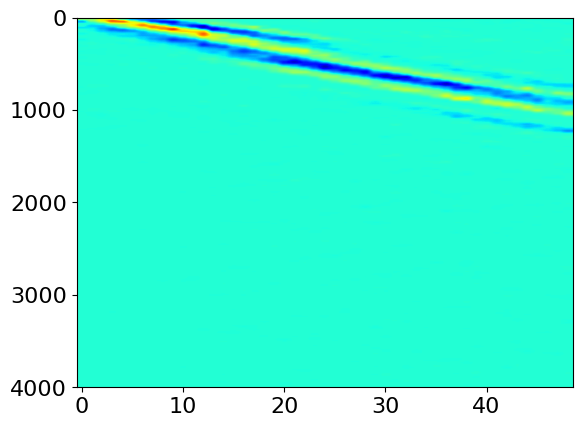

In [7]:
plt.imshow(bus_traces, aspect='auto', cmap='jet')

sampling loop time step: 100%|██████████| 2000/2000 [00:11<00:00, 181.79it/s]


(128, 128)


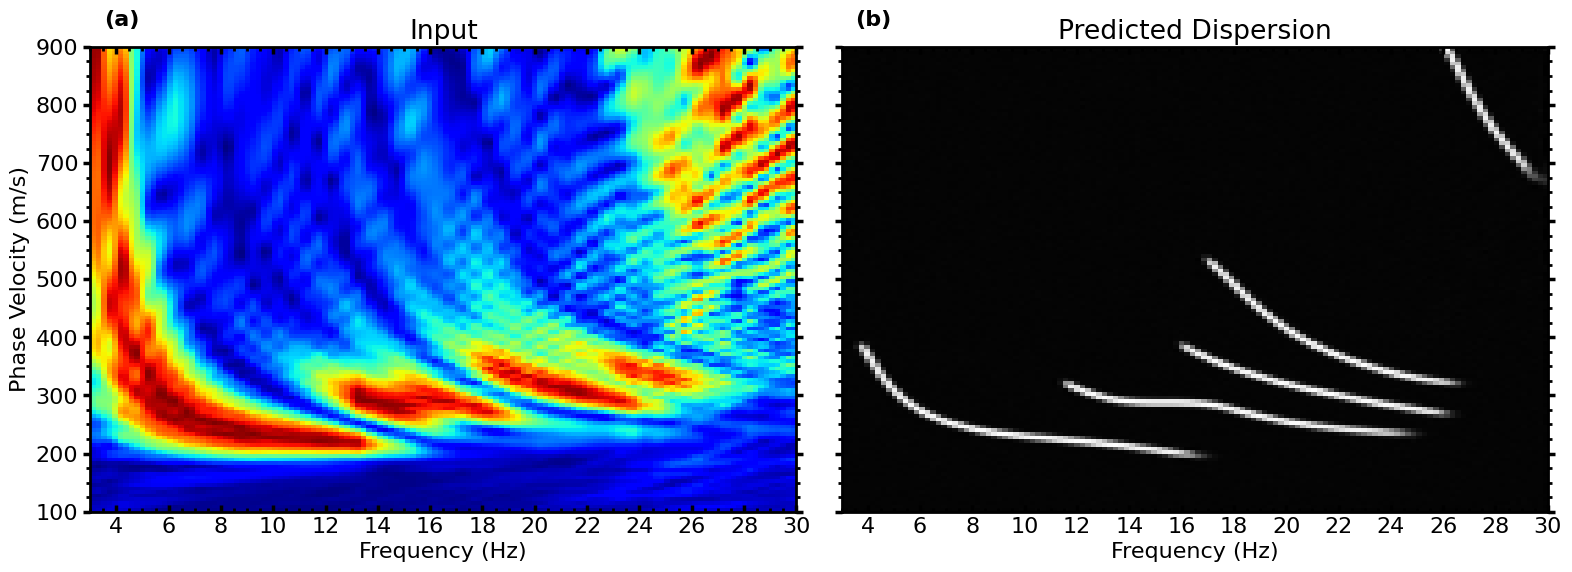

In [24]:
from PIL import Image
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
img_data = Image.open('/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/diffseis/dataset/demultiple/data_train/test/true001.png')

x_start = test_transform(img_data)
x_start = torch.unsqueeze(x_start, dim=0)

out1 = diffusion.inference(x_in=x_start.cuda())

in_samples = out1[0,0].cpu().detach().numpy()
out_samples = out1[1,0].cpu().detach().numpy()
print(out_samples.shape)


plt.rcParams.update({
    # 'font.family': 'Arial',
    'font.size': 16
})

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].imshow(in_samples, aspect='auto', cmap='jet',extent=(fmin, fmax,c.min(), c.max()))
axes[0].set_xlim(fmin, fmax)
axes[0].set_ylim(c.min(), c.max())

axes[1].imshow(out_samples, cmap="Greys_r", aspect='auto', extent=(fmin, fmax,c.min(), c.max()))
axes[1].set_xlim(fmin, fmax)
axes[1].set_ylim(c.min(), c.max())

# 隐藏纵坐标值但保留刻度
axes[1].tick_params(axis='y', labelleft=False)  # 隐藏纵坐标值

axes[0].set_title("Input")
axes[1].set_title("Predicted Dispersion")
axes[0].set_xlabel("Frequency (Hz)")
axes[1].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Phase Velocity (m/s)")

for ax in axes:
    # 设置X轴
    ax.xaxis.set_major_locator(MultipleLocator(2))    # 每隔5单位设置一个主要刻度
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))   # 设置次要刻度，主要刻度之间4个小刻度
    # 调整主要刻度线的长度和宽度
    ax.tick_params(axis='x', which='major', length=5, width=2.5, direction='in', top=True, bottom=True)#, labeltop=True, labelbottom=True)  
    # 调整次要刻度线的长度和宽度
    ax.tick_params(axis='x', which='minor', length=3, width=2, direction='in', top=True, bottom=True)
    # 关闭次要刻度的数字标签
    ax.tick_params(axis='x', which='minor', labelbottom=False)

    ax.yaxis.set_major_locator(MultipleLocator(100))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='y', which='major', length=5, width=2.5, left=True, right=True)
    ax.tick_params(axis='y', which='minor', length=3, width=2, left=True, right=True)
    ax.tick_params(axis='y', which='minor', labelbottom=False)

    # 调整边框的粗细
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # 将所有边框的线宽设置为2.5

# 在每个子图的左上角添加标注 (a), (b), (c), (d)
labels = ['(a)', '(b)', '(c)', '(d)']
positions = [(0.07, 1.08), (0.07, 1.08), (0.07, 1.08), (0.07, 1.08)]  # 坐标调整以适应子图位置
for i, ax in enumerate(axes.flat):
    ax.text(positions[i][0], positions[i][1], labels[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.3'))


fig.tight_layout()

In [25]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis("off")
ax.imshow(out_samples, aspect='auto', cmap='Greys_r',
        extent=(fmin, fmax,c.min(), c.max()))

ax.margins(0)
ax.set_xlim(fmin, fmax)
ax.set_ylim(c.min(), c.max())
fig.savefig(f'/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/diffseis/dataset/demultiple/data_train/test/true003.png',
            dpi=300,bbox_inches='tight', pad_inches=0)
plt.close()



[[180 855]
 [180 856]
 [180 857]
 [180 858]
 [180 859]
 [180 860]
 [180 861]
 [180 862]
 [180 863]
 [180 864]] (42810, 2)


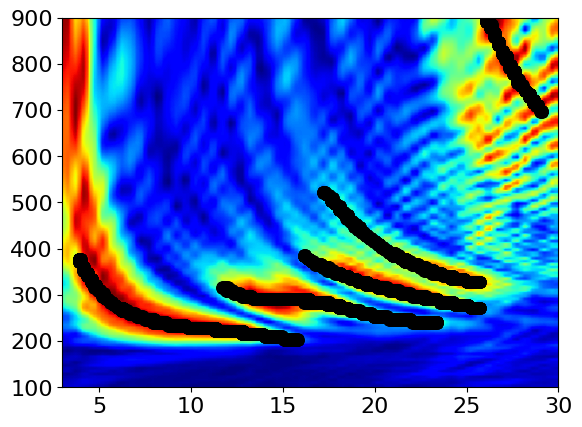

In [26]:
from PIL import Image
import numpy as np

# Load the image to analyze
image = Image.open('/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/diffseis/dataset/demultiple/data_train/test/true003.png')



# Convert image to grayscale (if it isn't already)
image_gray = image.convert('L')

# Convert to a numpy array to get pixel values
image_array = np.array(image_gray)[::-1]

# Get the positions of the white parts (assuming white is near 255 in grayscale)
threshold = 210  # Threshold for white pixel detection
white_pixel_positions = np.argwhere(image_array > threshold)

# Display the pixel positions
print(white_pixel_positions[:10], white_pixel_positions.shape)


plt.imshow(in_samples, aspect='auto', cmap='jet', extent=(fmin, fmax,c.min(), c.max()))
plt.xlim(fmin, fmax)
plt.ylim(c.min(), c.max())


f_new = np.linspace(fmin, fmax, image_array.shape[1])
c_new = np.linspace(c.min(), c.max(), image_array.shape[0])

plt.plot(f_new[white_pixel_positions[:, 1]], c_new[white_pixel_positions[:, 0]], 'ko')
plt.show()